In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import missingno as msno
from bokeh.core.properties import value
from bokeh.io import show,output_notebook
from bokeh.plotting import figure
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LogColorMapper
)
from bokeh.palettes import Viridis6 as palette
from bokeh.layouts import row
import nltk
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.sentiment import SentimentAnalyzer 

pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_colwidth', -1) # @Qumeng: caused futerwarning
pd.set_option('display.max_rows', None)  
%matplotlib inline

In [2]:
script = pd.read_csv("script.csv",encoding='utf-8')

In [3]:
script.head()

,Unnamed: 0,char,dialog,movie
0,0,DEAGOL,"Oh Smeagol Ive got one! , Ive got a fish Smeagol, Smeagol!",The Return of the King
1,1,SMEAGOL,"Pull it in! Go on, go on, go on, pull it in!",The Return of the King
2,2,DEAGOL,Arrghh!,The Return of the King
3,3,SMEAGOL,Deagol!,The Return of the King
4,4,SMEAGOL,Deagol!,The Return of the King


In [4]:
# sort by count, and draw bar chart shows the sentences spoken by different characters in total.
# script1 = script[script["count"]>=22]
# order = script1["char"].unique()
# char = script1["char"]
# a = char.value_counts()
# a = a.sort_values(ascending = False)[0:50]
# plt.figure(figsize=(20,10))
# b = a.plot(kind = "bar",color = "grey")

In [5]:
# #gourpby moives and characters
# grouped = script1.groupby(['char',"movie"]).count()
# grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
# grouped = grouped.reset_index()
# grouped = grouped.iloc[:,:3]
# grouped.columns = ["char","movie","count"]
# grouped.head()
# hue_order = np.array(["The Fellowship of the Ring","The Two Towers","The Return of the King"]).astype(object)

# Sentiment Analysis

In [6]:
import nltk
import re
from nltk.corpus import stopwords

rm_punctuation = lambda x : re.sub(r'[^A-Za-z]+', ' ', x)
rm_ewhite = lambda x: x.strip()
to_lower = lambda x: x.lower()
rm_num = lambda x: re.sub(r'\d+', '', x)
def remove_useless_words(sentence):
    excluded = ['no','not', 'nor', 'only', 'than', 'any', 'all',
                "thats","weve","hes","theres","ive","im","will",
                "can","cant","dont","youve","us","youre","youll",
                "theyre","whats","didnt" ]
    our_stop_words =[c for c in stopwords.words('english') if c not in excluded]
    result = ' '.join([word for word in sentence.split() if word not in (our_stop_words)])   
    return result

In [7]:
script.dropna(inplace=True)
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\46790\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
script["dialog"] = script["dialog"].apply(rm_punctuation)
script["dialog"]  = script["dialog"].apply(rm_ewhite)
script["dialog"]  = script['dialog'].apply(to_lower)
script["dialog"]  = script['dialog'].apply(rm_num)
script["dialog"] = script['dialog'].apply(remove_useless_words)

In [9]:
script['char'] = script['char'].apply(to_lower)

script['char'] = script['char'].replace(to_replace ='voiceover', value = '', regex=True)
script['char'] = script['char'].replace(to_replace ='voice over', value = '', regex=True)
script['char'] = script['char'].replace(to_replace ='voice-over', value = '', regex=True)
script['char'] = script['char'].replace(to_replace ='voice', value = '', regex=True)

script['char'] = script['char'].replace(to_replace ='mouth', value = '', regex=True)
script['char'] = script['char'].replace(to_replace ='eye', value = '', regex=True)
script['char'] = script['char'].replace(to_replace ='eye of', value = '', regex=True)

script['char'] = script['char'].replace(to_replace ='strider', value = 'aragorn', regex=True)
script['char'] = script['char'].replace(to_replace ='soldiers', value = 'soldier', regex=True)
script['char'] = script['char'].replace(to_replace ='soldiers', value = 'soldier', regex=True)
script['char'] = script['char'].replace(to_replace ='orcs', value = 'orc', regex=True)
script['char'] = script['char'].replace(to_replace ='merry and pippin', value = 'merry', regex=True)
script['char'] = script['char'].replace(to_replace ='merry AND pippin', value = 'pippin', regex=True)
script['char'] = script['char'].replace(to_replace ='gatekeepr', value = 'gatekeeper', regex=True)
script['char'] = script['char'].replace(to_replace ='argorn', value = 'aragorn', regex=True)
script['char'] = script['char'].replace(to_replace ='gan dalf', value = 'gandalf', regex=True)
script['char'] = script['char'].replace(to_replace ='gatekeeper', value = 'gatekeepr', regex=True)
script['char'] = script['char'].replace(to_replace ='smeagol', value = 'gollum', regex=True)
script['char'] = script['char'].replace(to_replace ='white wizard', value = 'gandalf', regex=True)

script['char'] = script['char'].apply(rm_punctuation)
script['char'] = script['char'].apply(rm_ewhite)
script['char'] = script['char'].apply(rm_num)
script['char'] = script['char'].apply(remove_useless_words)

pd.unique(script['char'])

array(['deagol', 'gollum', 'frodo', 'merry', 'gimli', 'sam', 'gandalf',
       'aragorn', 'pippin', 'hobbit', 'rosie', 'bilbo', 'treebeard',
       'saruman', 'theoden', 'galadril', 'elrond', 'grima', 'witch king',
       'eowyn', 'faramir', 'orc', 'soldier gate', 'gothmog', 'general',
       'captain', 'soldier', 'sauron', 'eomer', 'army', 'boson',
       'mercenary', 'eowyn merry', 'denethor', 'rohirrim', 'galadriel',
       'legolas', 'king dead', 'grimbold', 'irolas', 'gamling', 'madril',
       'damrod', 'soldier minas tirith', 'woman', 'haldir', 'old man',
       'boromir', 'crowd', 'arwen', 'hama', 'sharku', 'people', 'lady',
       'freda', 'morwen', 'rohan stableman', 'gorbag', 'ugluk', 'shagrat',
       'uruk hai', 'snaga', 'grishnakh', 'wildman', 'eothain',
       'rohan horseman', 'farmer maggot', 'gaffer', 'noakes', 'sandyman',
       'figwit', 'general shout', 'grishnak', 'mrs bracegirdle',
       'proudfoot hobbit', 'gatekeepr', 'man', 'children hobbits',
       'barlima

In [10]:
#add a column count how many sentenses spoken by the character in total
script["count"] = script["char"].map(lambda x: script["char"].tolist().count(x) )
script = script.sort_values("count",ascending = False)
script.head()

,Unnamed: 0,char,dialog,movie,count
653,653,frodo,holding sam,The Two Towers,229
223,223,frodo,smell,The Return of the King,229
814,814,frodo,can right sam tried tell sorry ring taking sam put find see,The Two Towers,229
248,248,frodo,destroy smeagol destroy sakes,The Return of the King,229
246,246,frodo,no,The Return of the King,229


In [11]:
#clean the data, little bit different from the last time
frodo =script[script["char"]=="frodo"]["dialog"].reset_index(drop=True).tolist()
sam =script[script["char"]=="sam"]["dialog"].reset_index(drop=True).tolist()
gandalf =script[script["char"]=="gandalf"]["dialog"].reset_index(drop=True).tolist()
aragorn =script[script["char"]=="aragorn"]["dialog"].reset_index(drop=True).tolist()
gollum =script[script["char"]=="gollum"]["dialog"].reset_index(drop=True).tolist()
pippin =script[script["char"]=="pippin"]["dialog"].reset_index(drop=True).tolist()
merry =script[script["char"]=="merry"]["dialog"].reset_index(drop=True).tolist()
arwen =script[script["char"]=="arwen"]["dialog"].reset_index(drop=True).tolist()
orc =script[script["char"]=="orc"]["dialog"].reset_index(drop=True).tolist()

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score

In [13]:
#generate a dictonary that make printing out the resault esiear.
charlist = {"frodo":frodo,"sam":sam,"gandalf":gandalf, "aragorn": aragorn,"gollum": gollum,"pippin":pippin,'merry':merry,"arwen":arwen,"orc":orc}

In [14]:
def flattena(t):
    return [item for sublist in t for item in sublist]
def flattenb(t):
    return [item for item in t]

In [15]:
#sentiment analysis
def sentimentA(char):
    vader = SentimentIntensityAnalyzer()
    res_dic = [vader.polarity_scores(text) for text in charlist[char]]
    res_dic = [res_dic[i] for i in range(len(res_dic)) if res_dic[i]["compound"]!=0]
    res_neg = np.mean([res_dic[i]['neg'] for i in range(len(res_dic))])
    res_pos = np.mean([res_dic[i]['pos'] for i in range(len(res_dic))])
    res_com = np.mean([res_dic[i]['compound'] for i in range(len(res_dic))])
#     print(char+":", res_com)    
    return res_com

In [16]:
sen = {}
for i in charlist:
    sen[i] = sentimentA(i)
sen

{'frodo': 0.07666666666666667,
 'sam': -0.08319797979797978,
 'gandalf': -0.01646060606060605,
 'aragorn': 0.0029137499999999927,
 'gollum': -0.008842016806722693,
 'pippin': 0.19337710843373493,
 'merry': 0.09299183673469388,
 'arwen': 0.05379375,
 'orc': 0.05315}

<BarContainer object of 9 artists>

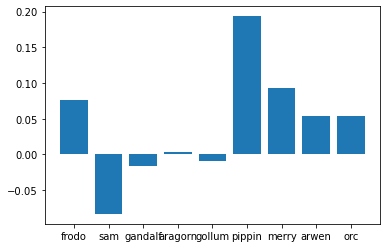

In [17]:
# calculate the score sentence by sentence.

sf = [*sen]
vf = [v for v in sen.values()]
plt.bar(sf, vf)

In [18]:
def sentimentB(char):
    v = nltk.sentiment.vader.SentimentIntensityAnalyzer()
    d3_all = ' '.join(charlist[char])
    return v.polarity_scores(d3_all)

In [19]:
senb = {}
# new method, just put all text in one string, and score it, rather than calculate the mean of all sentence.
for char in charlist:
    senb[char] =  sentimentB(char)['compound']
    print(char, ": ", sentimentB(char)['compound'])

frodo :  0.973
sam :  -0.998
gandalf :  -0.9956
aragorn :  0.9933
gollum :  -0.9972
pippin :  0.9992
merry :  0.9943
arwen :  -0.2649
orc :  -0.4795


[0.973, -0.998, -0.9956, 0.9933, -0.9972, 0.9992, 0.9943, -0.2649, -0.4795]
[ 1.06020176 -1.14397514 -1.14129121  1.08290332 -1.1430805   1.08950132
  1.08402163 -0.32414658 -0.56413459]


<BarContainer object of 9 artists>

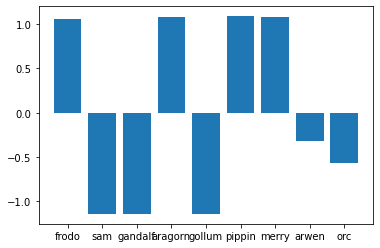

In [20]:
import scipy.stats as stats

# calculate the score all in once.

sfb = [*senb] # it should be fine if just use sf, rather than sfb.
vfb = [v for v in senb.values()]
print(vfb)
normalized = stats.zscore(vfb)
print(normalized)
plt.bar(sfb, normalized)

In [21]:
def sentimentC(char):
    vader = nltk.sentiment.vader.SentimentIntensityAnalyzer()
    d3 = flattena([ word.split() for word in charlist[char]])
    res_dic = [vader.polarity_scores(word) for word in d3]
    res_dic = [res_dic[i] for i in range(len(res_dic)) if res_dic[i]["compound"]!=0]
    res_neg = np.mean([res_dic[i]['neg'] for i in range(len(res_dic))])
    res_pos = np.mean([res_dic[i]['pos'] for i in range(len(res_dic))])
    res_com = np.mean([res_dic[i]['compound'] for i in range(len(res_dic))])
    return res_com

In [22]:
senc = {}
for i in charlist:
    senc[i] = sentimentC(i)
senc

{'frodo': 0.04621627906976744,
 'sam': -0.06779714285714286,
 'gandalf': -0.0387578125,
 'aragorn': -0.04919765624999999,
 'gollum': -0.021164157706093187,
 'pippin': 0.12285735294117647,
 'merry': 0.0938435294117647,
 'arwen': -0.028528571428571417,
 'orc': 0.11035000000000003}

<BarContainer object of 9 artists>

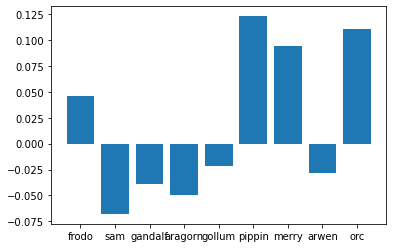

In [23]:
# calculate the score word by word
sfc = [*senc]
vfc = [v for v in senc.values()]
plt.bar(sfc, vfc)

## Their age.

Frodo Baggins - 50
Samwise Gamgee - 38
Gandalf - Approx. 2000 Years
Aragorn - 87
Legolas - Very Old
Gimli - 139
Meridoc Brandybuck - 36
Peregrin Took - 28
Boromir - 40

reference 

https://screenrant.com/lord-rings-fellowship-characters-ages-how-old/

https://www.statista.com/statistics/384102/age-of-selected-characters-in-lord-of-the-rings/

https://lotr.fandom.com/wiki/Arwen

In [24]:
ages = {
    'frodo': 50,
    'sam':38,
    'gandalf':2000,
    'aragorn':87,
    'gollum':589,
    'pippin':29,
    'merry' :37,
    'arwen':2901,
    'orc':50,
}

<BarContainer object of 9 artists>

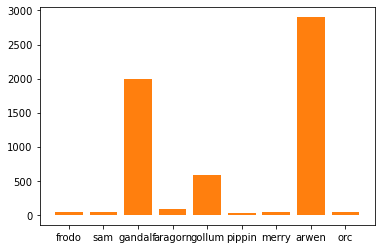

In [25]:
# calculate the score word by word
# sfc = [*senc]
# vfc = [v for v in senc.values()]
# plt.bar(sfc, vfc)
agek = [*ages]
agev = [v for v in ages.values()]
plt.bar(agek, agev)

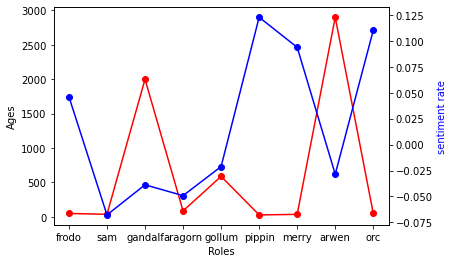

In [29]:
# plt.plot(agek,agev,marker='o', mec='r', mfc='w',label="age")
# plt.plot(sfc,vfc,marker='*', ms=10,label="sentiment")

fig,ax = plt.subplots()
ax.plot(agek,agev,color="red", marker="o")
ax.set_xlabel("Roles")
ax.set_ylabel("Ages")

ax2=ax.twinx()
ax2.plot(sfc, vfc,color="blue",marker="o")
ax2.set_ylabel("sentiment rate",color="blue")
plt.show()